In [1]:
def check_grad(model_ft):
    print("Parameters to learn:")
    params_to_update = []
    total_params = 0
    total_trainable_params = 0
    for name,param in model_ft.named_parameters():
        total_params+=param.numel()
        if param.requires_grad == True:
            params_to_update.append(param)
            total_trainable_params += param.numel()
            print("\t",name)
    print(f'{total_params:,} total parameters.')
    print(f'{total_trainable_params:,} training parameters.')
    return params_to_update

In [2]:
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
import time
import copy
from torch.nn import functional as F
import os
import csv
import io
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

---   
# HW3 - Transfer learning

#### Due October 30, 2019

In this assignment you will learn about transfer learning. This technique is perhaps one of the most important techniques for industry. When a problem you want to solve does not have enough data, we use a different (larger) dataset to learn representations which can help us solve our task using the smaller task.

The general steps to transfer learning are as follows:

1. Find a huge dataset with similar characteristics to the problem you are interested in.
2. Choose a model powerful enough to extract meaningful representations from the huge dataset.
3. Train this model on the huge dataset.
4. Use this model to train on the smaller dataset.


### This homework has the following sections:
1. Question 1: MNIST fine-tuning (Parts A, B, C, D).
2. Question 2: Pretrain on Wikitext2 (Part A, B, C, D)
3. Question 3: Finetune on MNLI (Part A, B, C, D)
4. Question 4: Finetune using pretrained BERT (Part A, B, C)

---   
## Question 1 (MNIST transfer learning)
To grasp the high-level approach to transfer learning, let's first do a simple example using computer vision. 

The torchvision library has pretrained models (resnets, vggnets, etc) on the Imagenet dataset. Imagenet is a dataset
with 1.3 million images covering over 1000 classes of objects. When you use one of these models, the weights of the model initialize
with the weights saved from training on imagenet.

In this task we will:
1. Choose a pretrained model.
2. Freeze the model so that the weights don't change.
3. Fine-tune on a few labels of MNIST.   

#### Choose a model
Here we pick any of the models from torchvision

In [3]:
import torchvision
print(torchvision.__version__)

0.4.1.post2


In [4]:
import torch
import torchvision.models as models
from torch import nn as nn
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

# init the pretrained feature extractor
pretrained_resnet18 = models.resnet18(pretrained=True)

# we don't want the built in last layer, we're going to modify it ourselves
pretrained_resnet18.fc = Identity()

In [30]:
pretrained_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Freeze the model
Here we freeze the weights of the model. Freezing means the gradients will not backpropagate
into these weights.

By doing this you can think about the model as a feature extractor. This feature extractor outputs
a **representation** of an input. This representation is a matrix that encodes information about the input.

In [5]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
        
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True
        
freeze_model(pretrained_resnet18)

In [6]:
_ = check_grad(pretrained_resnet18)

Parameters to learn:
11,176,512 total parameters.
0 training parameters.


#### Init target dataset
Here we define the dataset we are actually interested in.

In [7]:
import os
from torchvision import transforms
from torchvision.datasets import  MNIST
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F


#  train/val  split
mnist_dataset = MNIST(os.getcwd(), train=True, download=True, 
                      transform = transforms.Compose([
                          transforms.Resize((256,256)),
                          transforms.Grayscale(3),
                          transforms.ToTensor(),
                         transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225))]))
mnist_train, mnist_val = random_split(mnist_dataset, [55000, 5000])

mnist_train = DataLoader(mnist_train, batch_size=32,shuffle=True)
mnist_val = DataLoader(mnist_val, batch_size=32,shuffle=True)

# test split
mnist_test = DataLoader(MNIST(os.getcwd(), train=False, download=True, 
                              transform=transforms.Compose([
                                transforms.Resize((256,256)),
                                transforms.Grayscale(3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225))])
                             ), 
                        batch_size=32,
                        shuffle=False)

dataloaders = dict()
dataloaders['train'] = mnist_train
dataloaders['val'] = mnist_val


  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:03, 3074731.94it/s]                             


Extracting /Users/lexili24/Fall2019/CourseNLP/submission/HW3/MNIST/raw/train-images-idx3-ubyte.gz to /Users/lexili24/Fall2019/CourseNLP/submission/HW3/MNIST/raw


32768it [00:00, 503286.38it/s]
  1%|          | 16384/1648877 [00:00<00:11, 146899.58it/s]

Extracting /Users/lexili24/Fall2019/CourseNLP/submission/HW3/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/lexili24/Fall2019/CourseNLP/submission/HW3/MNIST/raw


1654784it [00:01, 1373741.29it/s]                             
8192it [00:00, 141863.39it/s]


Extracting /Users/lexili24/Fall2019/CourseNLP/submission/HW3/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/lexili24/Fall2019/CourseNLP/submission/HW3/MNIST/raw
Extracting /Users/lexili24/Fall2019/CourseNLP/submission/HW3/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/lexili24/Fall2019/CourseNLP/submission/HW3/MNIST/raw
Processing...
Done!


In [8]:
# check dataset
for images, targets in mnist_train:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', targets.shape)
    break

Image batch dimensions: torch.Size([32, 3, 256, 256])
Image label dimensions: torch.Size([32])


In [9]:
for images, targets in mnist_test:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', targets.shape)
    break

Image batch dimensions: torch.Size([32, 3, 256, 256])
Image label dimensions: torch.Size([32])


### Part A (init fine-tune model)
decide what model to use for fine-tuning

In [10]:
# ResNet
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class finetune_resnet(nn.Module):
    def __init__(self, input_size, n_classes, block, inplanes=512, planes = 1024, blocks = 2, stride=1, norm_layer=None):
        super(finetune_resnet, self).__init__()
        if norm_layer is None:
            self._norm_layer = nn.BatchNorm2d
            
        self.layer5 = self._make_layer(block, inplanes, planes, blocks , stride=2) 
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) ## new 
        self.fc = nn.Linear(planes * block.expansion, n_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
           # print(downsample)
        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(inplanes, planes, stride=1,downsample=None))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.layer5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.softmax(x)
        return x 

def init_fine_tune_model_resnet():
    return finetune_resnet(input_size= 512, n_classes=10, block=BasicBlock)

In [11]:
pretrained_resnet18_s = nn.Sequential(*list(pretrained_resnet18.children())[:-2])

### Part B (Fine-tune (Frozen))

The actual problem we care about solving likely has a different number of classes or is a different task altogether. Fine-tuning is the process of using the extracted representations (features) to solve this downstream task  (the task you're interested in).

To illustrate this, we'll use our pretrained model (on Imagenet), to solve the MNIST classification task.

There are two types of finetuning. 

#### 1. Frozen feature_extractor
In the first type we pretrain with the FROZEN feature_extractor and NEVER unfreeze it during finetuning.


#### 2. Unfrozen feature_extractor
In the second, we finetune with a FROZEN feature_extractor for a few epochs, then unfreeze the feature extractor and finish training.


In this part we will use the first version

In [15]:
def train_val(model_ft, optimizer, criterion, dataloaders, device, num_epochs, save_location): 
    '''
    This model takes input of multiple models and return trianing and validation losses 
    '''
    train_acc_history, val_acc_history = [], []
    best_acc = 0.0
    since = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 40)

        # Each epoch has a training and validation phase
        for phase, dataloader in dataloaders.items():
            if phase == 'train':
                model_ft.train()
            else:
                model_ft.eval()
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # why is it necessary?? 
                inputs.requires_grad = True
                
                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                
                    outputs = model_ft(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.max(outputs, 1)[1]

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_ft_dict = copy.deepcopy(model_ft.state_dict())
                best_model_ft = model_ft
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            
            
        _ = calculate_mnist_test_accuracy(model_ft)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    print('Saving best model at {}'.format(save_location))
    torch.save({
    'train_loss': train_acc_history,
    'val_loss': val_acc_history,
    'model_dict': best_model_ft_dict
            }, './{}.pt'.format(save_location))
    
    return best_model_ft, train_acc_history, val_acc_history

In [16]:
## abbrev version
def FROZEN_fine_tune_mnist(feature_extractor, fine_tune_model, dataloaders, num_epochs, location):
    """
    model is a feature extractor (resnet).
    Create a new model which uses those features to finetune on MNIST
    
    return the fine_tune model
    """         
    n_inputs = models.resnet18(pretrained=True).fc.in_features
    n_classes = 10

    # cpu/gpu
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # put model on device
    fine_tune_model = fine_tune_model()
    feature_extractor.fc = fine_tune_model
    feature_extractor.to(device)
    print('Training on', device)  
    params_to_update= check_grad(feature_extractor)  

    optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    criterion = nn.CrossEntropyLoss()

    print('Frozen feature extractor and train fine tune for {} epochs on {}'.format(num_epochs, device)) 
    
    
    best_model_ft, train_acc_history, val_acc_history = train_val(feature_extractor, 
                                                                     optimizer, 
                                                                     criterion, dataloaders,
                                                                      device,
                                                                     num_epochs, location)   

    
    
    return best_model_ft, train_acc_history, val_acc_history

In [17]:
def UNFROZEN_fine_tune_mnist(feature_extractor, fine_tune_model, dataloaders, num_epochs, location):
    """
    model is a feature extractor (resnet).
    Create a new model which uses those features to finetune on MNIST
    
    return the fine_tune model
    """     
    # INSERT YOUR CODE:
    n_inputs = models.resnet18(pretrained=True).fc.in_features
    n_classes = 10
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    fine_tune_model = fine_tune_model()

    criterion = nn.CrossEntropyLoss()
    
    # Frozen First 
    model_fr = feature_extractor
    freeze_model(model_fr)
    model_fr.fc = fine_tune_model
    model_fr.to(device)
    print('Frist freeze feature extractor and only train finetune model for {} epochs on {}'.format(num_epochs, device)) 
    params_to_update = check_grad(model_fr)
    optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    best_model_ft, train_acc_history_f, val_acc_history_f = train_val(model_fr, 
                                                                     optimizer, 
                                                                     criterion, dataloaders,
                                                                     device, num_epochs,
                                                                     location)


    
    # Train on the all model
    unfreeze_model(best_model_ft)
    best_model_ft.to(device)
    print('Next unfreeze feature extractor and train both models for {} epochs on {}'.format(num_epochs, device)) 
    params_to_update = check_grad(best_model_ft) # make sure all grads are now require_grad
    optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9) # update the trainable parameters
    best_model_ft, train_acc_history_unf, val_acc_history_unf = train_val(best_model_ft, 
                                                                     optimizer, 
                                                                     criterion, dataloaders,
                                                                     device, num_epochs,
                                                                     location)


    return best_model_ft, train_acc_history_f+train_acc_history_unf, val_acc_history_f + val_acc_history_unf


### Part C (compute test accuracy)
Compute the test accuracy of fine-tuned model on MNIST

In [12]:
def calculate_mnist_test_accuracy(feature_extractor, fine_tune_model = None):
    
    test_correct = 0 # YOUR CODE HERE...
    test_loss = 0
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    if fine_tune_model:
        feature_extractor.fc = fine_tune_model()   
        
    feature_extractor.to(device)
    feature_extractor.eval()

    criterion = nn.CrossEntropyLoss()
    
    for inputs, labels in mnist_test:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = feature_extractor(inputs)

        outputs = F.softmax(logits, dim =1)

        preds = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        # statistics
        test_loss += loss.item() * labels.size(0)
        test_correct += preds.eq(labels.view_as(preds).to(device)).sum().item()

    epoch_loss = test_loss / len(mnist_test.dataset)
    epoch_acc = test_correct / len(mnist_test.dataset)
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    return epoch_acc, epoch_loss

### Grade!
Let's see how you did

In [19]:
def grade_mnist_frozen():
    freeze_model(pretrained_resnet18_s)

    # run the transfer learning routine
    #model_frozen, train_froz, val_froz = FROZEN_fine_tune_mnist(pretrained_resnet18, init_fine_tune_model, 
    #                                                            dataloaders, num_epochs= 10, location='best_frozen_mlp')
    model_frozen, train_froz, val_froz = FROZEN_fine_tune_mnist(pretrained_resnet18_s, init_fine_tune_model_resnet,
                                                                dataloaders, num_epochs=6, location='best_frozen_resnet')
    # calculate test accuracy
    test_accuracy, test_loss = calculate_mnist_test_accuracy(model_frozen)
    
    # the real threshold will be released by Oct 11 
    assert test_accuracy > 80.0, 'your accuracy is too low...'
    
    return test_accuracy
    
frozen_test_accuracy = grade_mnist_frozen()


Training on cuda:0
Parameters to learn:
	 fc.layer5.0.conv1.weight
	 fc.layer5.0.bn1.weight
	 fc.layer5.0.bn1.bias
	 fc.layer5.0.conv2.weight
	 fc.layer5.0.bn2.weight
	 fc.layer5.0.bn2.bias
	 fc.layer5.0.downsample.0.weight
	 fc.layer5.0.downsample.1.weight
	 fc.layer5.0.downsample.1.bias
	 fc.layer5.1.conv1.weight
	 fc.layer5.1.bn1.weight
	 fc.layer5.1.bn1.bias
	 fc.layer5.1.conv2.weight
	 fc.layer5.1.bn2.weight
	 fc.layer5.1.bn2.bias
	 fc.fc.weight
	 fc.fc.bias
44,751,434 total parameters.
33,574,922 training parameters.
Frozen feature extractor and train fine tune for 6 epochs on cuda:0
Epoch 0/5
----------------------------------------
train Loss: 0.1340 Acc: 0.9609
val Loss: 0.0484 Acc: 0.9848
Test Loss: 1.6358 Acc: 0.8786
Epoch 1/5
----------------------------------------
train Loss: 0.0393 Acc: 0.9880
val Loss: 0.0364 Acc: 0.9892
Test Loss: 1.6099 Acc: 0.8879
Epoch 2/5
----------------------------------------
train Loss: 0.0204 Acc: 0.9940
val Loss: 0.0357 Acc: 0.9892
Test Loss:

In [1]:
# MD5 (best_frozen_resnet.pt) = 64818c86bb6992a675b40b269361dcc2

### Part D (Fine-tune Unfrozen)
Now we'll learn how to train using the "unfrozen" approach.

In this approach we'll:
1. keep the feature_extract frozen for a few epochs (10)
2. Unfreeze it.
3. Finish training

### Grade UNFROZEN
Let's see if there's a difference in accuracy!

In [20]:
def grade_mnist_unfrozen(frozen_test_accuracy = 80):
    
    # run the transfer learning routine
    best_unfroz, train_unfroz, val_unfroz = UNFROZEN_fine_tune_mnist(pretrained_resnet18_s, 
                                                                    init_fine_tune_model_resnet, 
                                                                     dataloaders, num_epochs=10, 
                                                                     location='best_unfrozen_resnet')
    
    # calculate test accuracy
    test_accuracy, test_loss = calculate_mnist_test_accuracy(best_unfroz)
    
    # the real threshold will be released by Oct 11 
    assert test_accuracy > frozen_test_accuracy, 'your accuracy is too low...'
    
    return test_accuracy
    
unfrozen_test_accuracy = grade_mnist_unfrozen(frozen_test_accuracy)

Frist freeze feature extractor and only train finetune model for 10 epochs on cuda:0
Parameters to learn:
	 fc.layer5.0.conv1.weight
	 fc.layer5.0.bn1.weight
	 fc.layer5.0.bn1.bias
	 fc.layer5.0.conv2.weight
	 fc.layer5.0.bn2.weight
	 fc.layer5.0.bn2.bias
	 fc.layer5.0.downsample.0.weight
	 fc.layer5.0.downsample.1.weight
	 fc.layer5.0.downsample.1.bias
	 fc.layer5.1.conv1.weight
	 fc.layer5.1.bn1.weight
	 fc.layer5.1.bn1.bias
	 fc.layer5.1.conv2.weight
	 fc.layer5.1.bn2.weight
	 fc.layer5.1.bn2.bias
	 fc.fc.weight
	 fc.fc.bias
44,751,434 total parameters.
33,574,922 training parameters.
Epoch 0/9
----------------------------------------
train Loss: 0.1327 Acc: 0.9614
val Loss: 0.0532 Acc: 0.9834
Test Loss: 1.6837 Acc: 0.8296
Epoch 1/9
----------------------------------------
train Loss: 0.0391 Acc: 0.9878
val Loss: 0.0404 Acc: 0.9880
Test Loss: 1.5906 Acc: 0.9129
Epoch 2/9
----------------------------------------
train Loss: 0.0200 Acc: 0.9940
val Loss: 0.0371 Acc: 0.9892
Test Loss: 1

In [21]:
assert unfrozen_test_accuracy > frozen_test_accuracy, 'the unfrozen model should be better'

In [2]:
# MD5 (best_unfrozen_resnet.pt) = fccf6b708d2c1bd595e55688c7a47582

In [14]:
fine_tune_model = init_fine_tune_model_resnet()
model = pretrained_resnet18_s
model.fc = fine_tune_model

model.load_state_dict(torch.load('best_frozen_resnet.pt',map_location=lambda storage, loc: storage)['model_dict'])
model.eval()

test_acc, test_loss = calculate_mnist_test_accuracy(model)

Test Loss: 1.4753 Acc: 0.9893


In [ ]:
fine_tune_model = init_fine_tune_model_resnet()
model = pretrained_resnet18_s
model.fc = fine_tune_model

model.load_state_dict(torch.load('best_unfrozen_resnet.pt',map_location=lambda storage, loc: storage)['model_dict'])
model.eval()

test_acc, test_loss = calculate_mnist_test_accuracy(model)

In [ ]:
plt.imshow(inputs[0].numpy()[:, :, 2].astype(np.float32), cmap=plt.get_cmap('gray'))

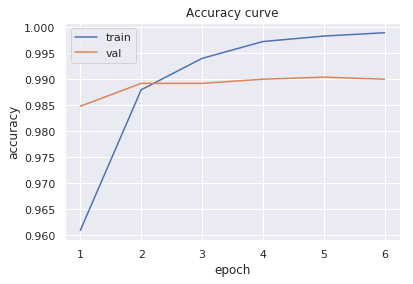

In [25]:
frozen_train_acc = torch.load('best_frozen_resnet.pt',map_location=lambda storage, loc: storage)['train_loss']
frozen_val_acc = torch.load('best_frozen_resnet.pt',map_location=lambda storage, loc: storage)['val_loss']

fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, len(frozen_train_acc), len(frozen_train_acc))
ax.plot(x, frozen_train_acc, label = 'train');
ax.plot(x, frozen_val_acc, label = 'val');
plt.title("Accuracy curve")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

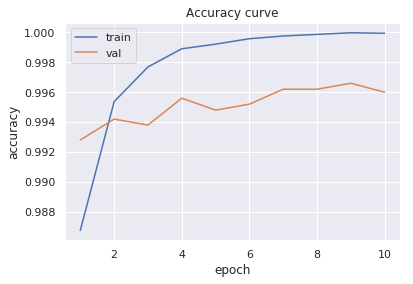

In [26]:
unfrozen_train_acc = torch.load('best_unfrozen_resnet.pt',map_location=lambda storage, loc: storage)['train_loss']
unfrozen_val_acc = torch.load('best_unfrozen_resnet.pt',map_location=lambda storage, loc: storage)['val_loss']

fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, len(unfrozen_train_acc), len(unfrozen_train_acc))
ax.plot(x, unfrozen_train_acc, label = 'train');
ax.plot(x, unfrozen_val_acc, label = 'val');
plt.title("Accuracy curve")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()